<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/EfficientNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 FER 데이터 학습



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/face_recognition/'

### 0. 라이브러리 호출

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import cv2
import time

### 1. FER 데이터 로드 및 준비


In [4]:
data = pd.read_csv(path + "data/face_emotion.csv")
data.head()

,emotion,pixels,Usage
0,0,195 184 176 178 179 182 184 181 177 171 164 17...,Training
1,0,87 85 80 75 74 76 76 75 73 73 74 76 80 82 86 8...,Training
2,0,154 153 205 179 180 174 158 99 123 135 172 203...,Training
3,0,208 219 226 213 211 178 86 95 100 103 104 104 ...,Training
4,0,61 56 50 46 43 39 36 33 31 30 29 28 26 24 23 2...,Training


In [5]:
len(data)

60000

- 용량이 너무 커서 클래스별로 나눠서 처리

emotion
0    10000
1    10000
2    10000
3    10000
5    10000
4    10000
Name: count, dtype: int64


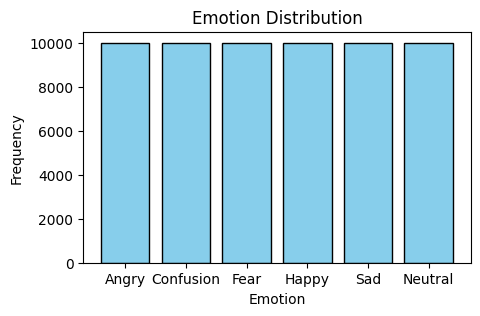

In [6]:
# 감정 매핑
emotion_mapping = {0:'Angry', 1:'Confusion', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Neutral'}

# 고유값 및 빈도 확인
emotion_counts = data["emotion"].value_counts()
print(emotion_counts)

# 히스토그램 그리기
plt.figure(figsize=(5, 3))
plt.bar(emotion_mapping.values(), [emotion_counts.get(i, 0) for i in emotion_mapping.keys()], color='skyblue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Frequency")

plt.show()

In [7]:
# usage 컬럼 제거
data = data.drop(columns=["Usage"])

# emotion별로 데이터 분리 및 새로운 데이터프레임 할당
df0 = data[data["emotion"] == 0].reset_index(drop=True)
df0 = df0.iloc[:10000]
df1 = data[data["emotion"] == 1].reset_index(drop=True)
df1 = df1.iloc[:10000]
df2 = data[data["emotion"] == 2].reset_index(drop=True)
df2 = df2.iloc[:10000]
df3 = data[data["emotion"] == 3].reset_index(drop=True)
df3 = df3.iloc[:10000]
df4 = data[data["emotion"] == 4].reset_index(drop=True)
df4 = df4.iloc[:10000]
df5 = data[data["emotion"] == 5].reset_index(drop=True)
df5 = df5.iloc[:10000]

# 결과 출력 (각 데이터프레임의 샘플 개수 확인)
print(f"df0: {len(df0)} rows")
print(f"df1: {len(df1)} rows")
print(f"df2: {len(df2)} rows")
print(f"df3: {len(df3)} rows")
print(f"df4: {len(df4)} rows")
print(f"df5: {len(df5)} rows")

df0: 10000 rows
df1: 10000 rows
df2: 10000 rows
df3: 10000 rows
df4: 10000 rows
df5: 10000 rows


In [8]:
def preprocess(data):
    # 픽셀 데이터를 효율적으로 처리
    def process_pixels(pixel_str, index):
        try:
            pixels = np.array(pixel_str.split(), dtype='float32') / 255.0
            if len(pixels) != 2304:  # 48x48 크기가 아닌 경우 처리
                print(f"Invalid pixel length at index {index}: {len(pixels)}")
                return None
            return pixels
        except ValueError:
            print(f"Invalid pixel data at index {index}: {pixel_str}")
            return None

    # 픽셀 데이터 처리
    valid_pixels = []
    valid_labels = []
    for i, (pixel_str, label) in enumerate(zip(data['pixels'], data['emotion'])):
        processed = process_pixels(pixel_str, i)
        if processed is not None:
            valid_pixels.append(processed)
            valid_labels.append(label)

    # NumPy 배열로 변환
    pixels = np.array(valid_pixels).reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지
    pixels = np.repeat(pixels, 3, axis=-1)  # 3채널로 확장
    labels = to_categorical(valid_labels, num_classes=6)

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [9]:
X_train0, X_val0, y_train0, y_val0 = preprocess(df0)
print(f"Shapes-> X_train0: {X_train0.shape}, X_val0: {X_val0.shape}, y_train0: {y_train0.shape}, y_val0: {y_val0.shape}")

Shapes-> X_train0: (8000, 48, 48, 3), X_val0: (2000, 48, 48, 3), y_train0: (8000, 6), y_val0: (2000, 6)


In [10]:
X_train1, X_val1, y_train1, y_val1 = preprocess(df1)
print(f"Shapes-> X_train1: {X_train1.shape}, X_val1: {X_val1.shape}, y_train1: {y_train1.shape}, y_val1: {y_val1.shape}")

Shapes-> X_train1: (8000, 48, 48, 3), X_val1: (2000, 48, 48, 3), y_train1: (8000, 6), y_val1: (2000, 6)


In [11]:
X_train2, X_val2, y_train2, y_val2 = preprocess(df2)
print(f"Shapes-> X_train2: {X_train2.shape}, X_val2: {X_val2.shape}, y_train2: {y_train2.shape}, y_val2: {y_val2.shape}")

Shapes-> X_train2: (8000, 48, 48, 3), X_val2: (2000, 48, 48, 3), y_train2: (8000, 6), y_val2: (2000, 6)


In [12]:
X_train3, X_val3, y_train3, y_val3 = preprocess(df3)
print(f"Shapes-> X_train3: {X_train3.shape}, X_val3: {X_val3.shape}, y_train3: {y_train3.shape}, y_val3: {y_val3.shape}")

Shapes-> X_train3: (8000, 48, 48, 3), X_val3: (2000, 48, 48, 3), y_train3: (8000, 6), y_val3: (2000, 6)


In [13]:
X_train4, X_val4, y_train4, y_val4 = preprocess(df4)
print(f"Shapes-> X_train4: {X_train4.shape}, X_val4: {X_val4.shape}, y_train4: {y_train4.shape}, y_val4: {y_val4.shape}")

Shapes-> X_train4: (8000, 48, 48, 3), X_val4: (2000, 48, 48, 3), y_train4: (8000, 6), y_val4: (2000, 6)


In [14]:
X_train5, X_val5, y_train5, y_val5 = preprocess(df5)
print(f"Shapes-> X_train5: {X_train5.shape}, X_val5: {X_val5.shape}, y_train5: {y_train5.shape}, y_val5: {y_val5.shape}")

Shapes-> X_train5: (8000, 48, 48, 3), X_val5: (2000, 48, 48, 3), y_train5: (8000, 6), y_val5: (2000, 6)


In [15]:
# 병합
X_train = np.concatenate([X_train0, X_train1, X_train2, X_train3, X_train4, X_train5], axis=0)
del X_train0, X_train1, X_train2, X_train3, X_train4, X_train5  # X_train 관련 변수 삭제

X_val = np.concatenate([X_val0, X_val1, X_val2, X_val3, X_val4, X_val5], axis=0)
del X_val0, X_val1, X_val2, X_val3, X_val4, X_val5  # X_val 관련 변수 삭제

y_train = np.concatenate([y_train0, y_train1, y_train2, y_train3, y_train4, y_train5], axis=0)
del y_train0, y_train1, y_train2, y_train3, y_train4, y_train5  # y_train 관련 변수 삭제

y_val = np.concatenate([y_val0, y_val1, y_val2, y_val3, y_val4, y_val5], axis=0)
del y_val0, y_val1, y_val2, y_val3, y_val4, y_val5  # y_val 관련 변수 삭제

# 합친 데이터의 형태 확인
print(f"Shapes-> X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

Shapes-> X_train: (48000, 48, 48, 3), X_val: (12000, 48, 48, 3), y_train: (48000, 6), y_val: (12000, 6)


### 2. 모델 로드

**- 표정 분류 모델**

In [16]:
# 얼굴 인식 함수
def detect_face(frame):
    cascPath = path + 'model/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(48, 48),  # 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(detected_faces) > 0:
        return gray, detected_faces[0]  # 첫 번째 얼굴만 처리
    else:
        return gray, None  # 얼굴이 탐지되지 않으면 None 반환

In [17]:
# 얼굴 특징 추출 함수
def extract_face_features(gray, detected_face, offset_coefficients=(0.075, 0.05), shape_x=48, shape_y=48):
    if detected_face is None:
        return None  # 얼굴이 없으면 None 반환

    x, y, w, h = detected_face

    horizontal_offset = int(np.floor(offset_coefficients[0] * w))
    vertical_offset = int(np.floor(offset_coefficients[1] * h))

    # 추출할 얼굴 영역 설정
    extracted_face = gray[
        y + vertical_offset : y + h,
        x + horizontal_offset : x - horizontal_offset + w
    ]

    # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
    new_extracted_face = zoom(
        extracted_face,
        (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
    )

    # 데이터를 float32 형식으로 변환
    new_extracted_face = new_extracted_face.astype(np.float32)

    # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
    new_extracted_face /= float(new_extracted_face.max())

    # 정규화된 얼굴 이미지를 반환
    return new_extracted_face

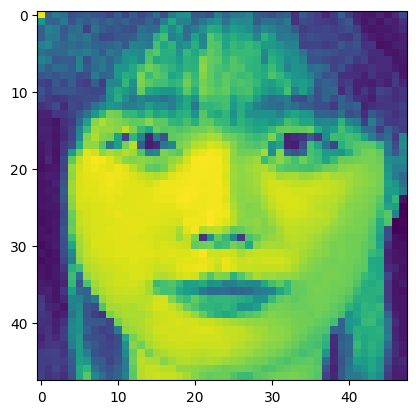

In [18]:
img = cv2.imread(path + "test_data/img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    plt.imshow(extracted_face)
else:
    print("No face detected in the image.")

**- 얼굴 인식 모델**

- 모델 생성 및 수정: 사전 학습된 가중치는 고정하고 새로운 출력 레이어만 학습

In [27]:
def create_model():
    # EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # 상위 레이어 학습을 위한 설정
    for layer in base_model.layers:
        layer.trainable = False  # 초기에는 base_model의 가중치를 고정

    # 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
    x = Dense(128, activation='relu')(x)  # 추가 Fully Connected Layer
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

### 3. 표정 분류 모델 학습

- 첫 번째 학습: 사전 가중치 고정하여 특징 추출

In [28]:
def feature_extraction_model(X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=32, epochs=10):
    model = create_model()

    # 사전 학습된 가중치 잠금 (Feature Extraction)
    for layer in model.layers:
        layer.trainable = False  # EfficientNet 가중치 고정

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return model, history

In [29]:
# Feature Extraction 학습
fe_model, fe_history = feature_extraction_model(X_train, y_train, X_val ,y_val)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.1686 - loss: 1.8271 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.1637 - loss: 1.8322 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1683 - loss: 1.8297 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1633 - loss: 1.8293 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1653 - loss: 1.8313 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.1689 - loss: 1.8270 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.1671 - loss: 1.8280 - val_accuracy: 0.1667 - val_loss: 1.8280
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1661 - loss:

- 두 번째 학습: 가중치 조정하고 추가 학습

In [30]:
def fine_tune_model(model, X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=32, epochs=30):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    # EarlyStopping 콜백 정의
    early_stopping = EarlyStopping(
        monitor='val_loss',  # validation loss를 기준으로 모니터링
        patience=10,  # 개선되지 않을 때 종료할 epoch 수
        restore_best_weights=True,  # 가장 성능이 좋은 가중치를 복원
        verbose=1           # 로그 출력 활성화
    )

    # 모델 Fine-Tuning 학습
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    return model, history

In [31]:
# Fine-Tuning 학습
ft_model, ft_history = fine_tune_model(fe_model, X_train, y_train, X_val, y_val)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 117s 31ms/step - AUC: 0.6406 - Precision: 0.5052 - Recall: 0.0573 - accuracy: 0.2921 - loss: 1.6928 - val_AUC: 0.7435 - val_Precision: 0.6097 - val_Recall: 0.1991 - val_accuracy: 0.3968 - val_loss: 1.4921
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - AUC: 0.7644 - Precision: 0.6884 - Recall: 0.1943 - accuracy: 0.4185 - loss: 1.4336 - val_AUC: 0.7644 - val_Precision: 0.6771 - val_Recall: 0.2114 - val_accuracy: 0.4185 - val_loss: 1.4354
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - AUC: 0.8095 - Precision: 0.7156 - Recall: 0.2658 - accuracy: 0.4694 - loss: 1.3179 - val_AUC: 0.8184 - val_Precision: 0.7349 - val_Recall: 0.2640 - val_accuracy: 0.4816 - val_loss: 1.2925
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - AUC: 0.8411 - Precision: 0.7407 - Recall: 0.3235 - accuracy: 0.5126 - loss: 1.2198 - val_AUC: 0.8061 - val_Precision: 0.6416 - val_Recall: 0.3247 - val_accuracy: 0.4629 - val_loss: 1.3489
Epoch 5/30
1500

### 4. 모델 평가

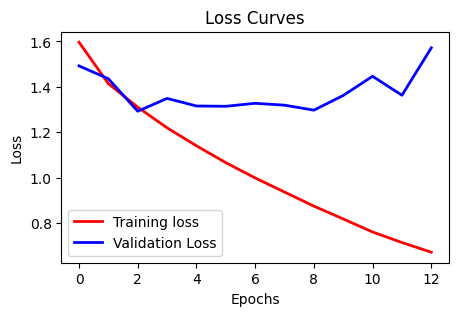

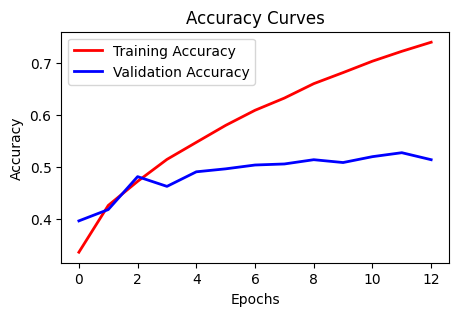

In [32]:
def plot_training_history(history):
    # 1. 손실 함수 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], 'r', linewidth=2.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
    plt.legend(['Training loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

    # 2. 정확도 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    plt.show()

plot_training_history(ft_history)

### 5. 모델 저장 및 호출

In [33]:
ft_model.save('model.h5')

In [34]:
new_model = load_model('model.h5')

### 5. 예측

In [35]:
# 감정 라벨
emotion_labels = ['Angry', 'Confusion', 'Fear', 'Happy', 'Sad', 'Neutral']

- 사진 예측

In [36]:
img = cv2.imread(path + "test_data/img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    if extracted_face is not None:
        # 예시: 모델에 입력하기 전에 이미지를 3채널로 확장 (EfficientNet 입력 요구 사항)
        extracted_face = np.repeat(extracted_face, 3, axis=-1)  # 1채널을 3채널로 변환
        extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

        # 예측 (모델은 이미 로드되어 있다고 가정)
        res = new_model.predict(extracted_face)
        result_num = np.argmax(res)
        print(f"표정 예측: {emotion_labels[result_num]}")
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
    else:
        print("얼굴 추출에 실패했습니다.")
else:
    print("얼굴을 찾을 수 없습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
표정 예측: Neutral
Class 0 (Angry): 3.03%
Class 1 (Confusion): 0.00%
Class 2 (Fear): 6.13%
Class 3 (Happy): 2.25%
Class 4 (Sad): 9.93%
Class 5 (Neutral): 78.66%


- 영상 예측(0.5초에 한번씩 캡쳐해서 이미지로 예측)

In [37]:
def process_video(video_path, model):
    emotion_labels = ['Angry', 'Confusion', 'Fear', 'Happy', 'Sad', 'Neutral']

    # 영상 파일 열기
    video_capture = cv2.VideoCapture(video_path)

    # 영상의 FPS 확인
    fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
    frame_interval = int(fps / 2)  # 0.5초 기준 프레임 간격 계산

    # 현재 시간
    frame_count = 0  # 프레임을 카운트하는 변수

    while True:
        # 영상에서 프레임 읽기
        ret, frame = video_capture.read()

        # 프레임이 제대로 읽어졌는지 확인
        if not ret:
            print("영상에서 프레임을 읽을 수 없습니다.")
            break

        # 지정한 간격마다 프레임 처리
        if frame_count % frame_interval == 0:
            # 얼굴 감지 및 특징 추출
            gray, detected_face = detect_face(frame)

            # 초 계산
            current_time_sec = frame_count / fps

            if detected_face is not None:
                # 얼굴 특징 추출
                extracted_face = extract_face_features(gray, detected_face)
                if extracted_face is not None:
                    # 1채널 이미지를 3채널로 확장
                    extracted_face = np.repeat(extracted_face, 3, axis=-1)
                    extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

                    # 예측 (모델은 이미 로드되어 있다고 가정)
                    res = model.predict(extracted_face)
                    result_num = np.argmax(res)
                    print(f"[{current_time_sec:.2f}초] 표정 예측: {emotion_labels[result_num]}")

                    # 각 클래스에 대한 확률을 출력
                    for i, prob in enumerate(res[0]):
                        print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
                else:
                    print("얼굴 추출에 실패했습니다.")
            else:
                print("얼굴을 찾을 수 없습니다.")

        # 프레임 카운트 증가
        frame_count += 1

    # 모든 작업 완료 후 캡처 리소스 해제
    video_capture.release()
    cv2.destroyAllWindows()


process_video(path + 'test_data/video.mp4', new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.00초] 표정 예측: Happy
Class 0 (Angry): 1.49%
Class 1 (Confusion): 0.03%
Class 2 (Fear): 2.48%
Class 3 (Happy): 67.54%
Class 4 (Sad): 2.55%
Class 5 (Neutral): 25.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.50초] 표정 예측: Neutral
Class 0 (Angry): 2.22%
Class 1 (Confusion): 0.01%
Class 2 (Fear): 5.87%
Class 3 (Happy): 10.71%
Class 4 (Sad): 11.35%
Class 5 (Neutral): 69.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[1.00초] 표정 예측: Neutral
Class 0 (Angry): 1.76%
Class 1 (Confusion): 0.00%
Class 2 (Fear): 4.58%
Class 3 (Happy): 5.97%
Class 4 (Sad): 7.69%
Class 5 (Neutral): 79.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1.50초] 표정 예측: Neutral
Class 0 (Angry): 3.46%
Class 1 (Confusion): 0.01%
Class 2 (Fear): 8.64%
Class 3 (Happy): 15.90%
Class 4 (Sad): 17.21%
Class 5 (Neutral): 54.79%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[2.00초] 표정 예측: Neutral
Class 0 (Angry): 2.67%
Class 1 (Confusion): 0.05%
Class 2 (Fear): 6.94%
Class 3 (Happy): 35.41%
Class 4 (Sad): 8.95%
Class 5